Implementamos la paquetería necesaria

In [1]:
using TaylorIntegration, ValidatedNumerics, TaylorSeries
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false)

Plots.PyPlotBackend()

In [2]:
const λ = 1.0
const Z = 2.0
const order = 28
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500000

500000

In [3]:
function undrivenHelium(τ, q)
    t, Q₁, P₁, Q₂, P₂ = q
    
    t = Q₁^2*Q₂^2
    q₁ = 0.25*Q₂^2*P₁
    p₁ = 2Q₁*(-0.125P₂^2 + Z  - Q₂^2 - Q₂^2/abs(Q₁^2 - Q₂^2)) + 2*Q₁^3*Q₂^2*((Q₁^2 - Q₂^2)/abs(Q₁^2 - Q₂^2)^3)
    q₂ = 0.25*Q₁^2*P₂
    p₂ = 2Q₂*(-0.125P₁^2 + Z  - Q₁^2 - Q₁^2/abs(Q₁^2 - Q₂^2)) - 2*Q₁^2*Q₂^3*((Q₁^2 - Q₂^2)/abs(Q₁^2 - Q₂^2)^3)

    return [t, q₁, p₁, q₂, p₂] 

end
undrivenHelium(v) = undrivenHelium(0, v)

undrivenHelium (generic function with 2 methods)

In [4]:
var1 = set_variables("t q1 p1 q2 p2", order = 1)

5-element Array{TaylorSeries.TaylorN{Float64},1}:
   1.0 t + 𝒪(‖x‖²)
  1.0 q1 + 𝒪(‖x‖²)
  1.0 p1 + 𝒪(‖x‖²)
  1.0 q2 + 𝒪(‖x‖²)
  1.0 p2 + 𝒪(‖x‖²)

In [5]:
function condini(x10::Float64, px10::Float64)
    @assert x10 != 0
    Q1 = sqrt(x10)
    Q2 = 0.0
    P1 = px10*sqrt(x10)    
    P2 = sqrt(8Z)    
    return [0, Q1, P1, Q2, P2]
end

condini (generic function with 1 method)

In [6]:
function regHam(t, Q₁, P₁, Q₂, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nf = sqrt(((Q₁)^2 - (Q₂)^2)^2)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end


regHam(v) = regHam(v...)

regHam (generic function with 2 methods)

In [7]:
tay1 = (regHam(var1 + rand(5)))
tay2 = tay1.coeffs[2]

 - 3.6744628544402884 q1 + 0.0008398049580423191 p1 - 0.0041093824754036 q2 + 0.20751660672557978 p2

In [8]:
tay2.coeffs

5-element Array{Float64,1}:
  0.0        
 -3.67446    
  0.000839805
 -0.00410938 
  0.207517   

In [7]:
function errHam(N::Int)
    dQ1 = zeros(N)
    dQ2 = zeros(N)
    dP1 = zeros(N)
    dP2 = zeros(N)
    als = typeof(zeros(5))[]
    for j in 1:N
        al = 10*rand(5)
        alt = al + var1
        ene = regHam(alt)
        meq = undrivenHelium(al)
        
        dQ1[j] = abs(meq[2] - ene.coeffs[2].coeffs[3])
        dQ2[j] = abs(meq[4] - ene.coeffs[2].coeffs[5])
        dP1[j] = abs(meq[3] + ene.coeffs[2].coeffs[2])
        dP2[j] = abs(meq[5] + ene.coeffs[2].coeffs[4])
        push!(als, al)
    end
    return dQ1, dQ2, dP1, dP2, als        
end

errHam (generic function with 1 method)

In [36]:
dQ1, dQ2, dP1, dP2, als = errHam(20);


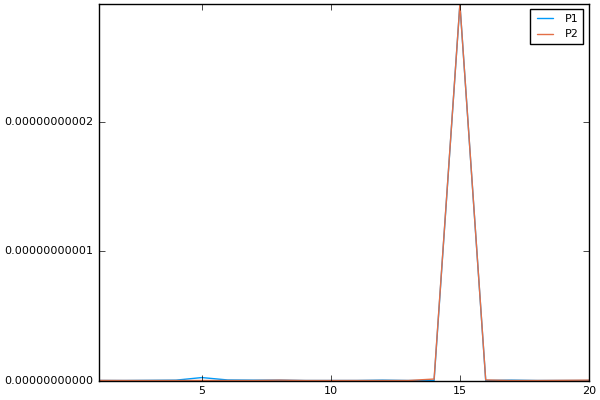

In [14]:
plot(eachindex(dP1), dP1, label ="P1", title = "")
plot!(eachindex(dP2), dP2, label = "P2",legend = :true)

In [22]:
q0 = condini(10.0, 1.1)

5-element Array{Float64,1}:
 0.0    
 3.16228
 3.47851
 0.0    
 4.0    

In [23]:
regHam(q0)

0.0

In [24]:
t, q = taylorinteg(undrivenHelium, q0, t0, 0.01, order, abs_tol, maxsteps=2); #warm-up lap
@time t, q = taylorinteg(undrivenHelium, q0, t0, 10.0, order, abs_tol, maxsteps=steps);

  0.695521 seconds (8.80 M allocations: 899.699 MB, 22.85% gc time)


The final state:

In [25]:
t[end], q[end,:]

(10.0,[1267.8,22.3579,16.7032,0.896604,-3.02208])

In [37]:
regHam(q[end,:])

-2.2737367544323206e-12

In [38]:
length(t), size(q)

(1697,(1697,5))

In [32]:
ene = zeros(t)
for j in eachindex(ene)
    ene[j] = abs(regHam(q[j,:]))
end


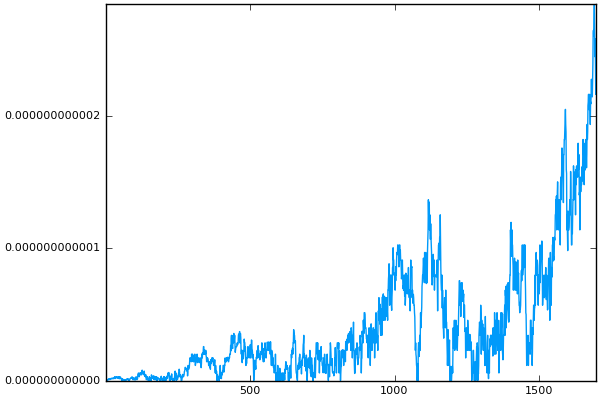

In [35]:
plot(eachindex(ene), ene)

In [ ]:
function ksv(Q, P)
    v₁ = (Q*P)
    return v₁
end
ks(Q) = Q^2